## SVC Classifier
The model predicts the severity of the landslide (or if there will even be one) within the next 2 days, based on weather data from the past 5 days.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.utils import shuffle
import pickle

In [56]:
# df = pd.read_csv("full_dataset_v1.csv")
df = pd.read_csv("dataset.csv")
len(df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


17808

In [57]:
df['severity'].value_counts()

medium          5594
small           2612
unknown          834
large            679
...              359
very_large       102
Medium            72
Unknown           19
Large             17
Small             10
catastrophic       4
landslide          2
Very_large         1
Very...large       1
Name: severity, dtype: int64

In [58]:
# filter by severity. na is for non-landslide data
# df = df[df['severity'].isin(["medium", "small", "large", "very_large", "na"])]
# Remove -1 slopes
# df = df.loc[~(df.slope == -1)]

In [59]:
df['severity'].value_counts()
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print(len(df))

17808


In [60]:
df = df.query("(landslide == 0) | (landslide == 1 & (severity == 'medium' | severity == 'small' | severity == 'large' | severity=='very_large'))")
df
X = df.copy()
y = []
for idx, row in X.iterrows():
    if row.landslide == 0:
        y.append(0)
    elif row.severity == 'small':
        y.append(1)
    elif row.severity == 'medium':
        y.append(2)
    else:
        y.append(3)
columns=[]
for i in range(9, 4, -1):
    columns.append('humidity' + str(i))
    columns.append('ARI' + str(i))
    columns.append('wind' + str(i))
columns.append('slope')
columns.append('forest2')
columns.append('osm')
X = X[columns]
X

,humidity9,ARI9,wind9,humidity8,ARI8,wind8,humidity7,ARI7,wind7,humidity6,ARI6,wind6,humidity5,ARI5,wind5,slope,forest2,osm
0,93,0.039688,21,98,0.226000,16,98,3.774060,28,96,1.675710,22,88,0.672030,24,5.334,1,786
1,98,0.029104,17,99,0.020211,13,59,0.014849,31,98,0.198439,30,99,0.380342,15,1.168,1,3466
2,99,1.399766,15,99,0.809998,11,100,1.632222,11,99,2.085284,18,99,0.750174,7,20.933,1,2721
3,96,1.949418,7,96,2.465483,10,97,2.421954,7,96,3.307102,12,97,2.434339,9,4.955,1,59954
4,98,1.312565,7,99,0.458217,10,97,2.226045,5,98,6.133194,8,98,12.797939,6,26.444,1,3519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17803,93,4.445037,6,94,4.571782,8,97,33.132867,27,95,9.539085,20,94,4.802067,15,33.675,1,2816
17804,100,2.384951,9,100,2.353811,10,100,1.552674,7,100,1.713802,8,100,0.601693,4,21.648,1,14265
17805,91,2.759326,22,88,3.380598,18,88,1.007805,6,80,0.464696,9,90,0.273038,15,22.361,1,16879
17806,83,0.023886,41,90,0.017549,31,76,0.000000,25,48,0.000000,61,51,0.000000,37,0.893,0,45


## Scaling

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA

In [62]:
from sklearn.decomposition import PCA
pca = PCA(0.9)

principalComponents = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.36587057, 0.16230077, 0.13486293, 0.05835025, 0.05509266,
       0.04061275, 0.03620369, 0.02780216, 0.02575913])

In [63]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [64]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', verbose = True)

In [65]:
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(verbose=True)

In [66]:
from sklearn.metrics import accuracy_score
pred = svclassifier.predict(X_test)
print("ACCURACY:" ,accuracy_score(pred, y_test))

ACCURACY: 0.6813220133414191


## Testing gamma and c

In [67]:
from sklearn.metrics import accuracy_score
C_range =[1, 10, 100]
gamma_range = [0.1, 1, 10, 100]
for c in C_range:
    for g in gamma_range:
        svc2 = SVC(kernel='rbf', gamma=g,C=c, verbose = True)
        svc2.fit(X_train, y_train)
        print(c, g, ":",accuracy_score(y_test, svc2.predict(X_test)))

[LibSVM]1 0.1 : 0.6825348696179503
[LibSVM]1 1 : 0.6646452395391146
[LibSVM]1 10 : 0.5151607034566403
[LibSVM]1 100 : 0.4681625227410552
[LibSVM]10 0.1 : 0.6849605821710127
[LibSVM]10 1 : 0.6315949060036385
[LibSVM]10 10 : 0.5251667677380231
[LibSVM]10 100 : 0.47028502122498483
[LibSVM]100 0.1 : 0.6755609460278957
[LibSVM]100 1 : 0.5991510006064281
[LibSVM]100 10 : 0.5254699818071559
[LibSVM]100 100 : 0.469981807155852


In [68]:
svc2 = SVC(kernel='rbf', gamma=0.1,C=10, verbose = True)
svc2.fit(X_train, y_train)
accuracy_score(y_test, svc2.predict(X_test))

[LibSVM]

0.6849605821710127

In [44]:
pred = svc2.predict(X_test)
print("ACCURACY:" ,accuracy_score(pred, y_test))

ACCURACY: 0.6885991510006064


## Confusion Matrix

In [1]:
from sklearn.metrics import confusion_matrix
array = [[1336,   14,  153,    1],
       [ 119,   43,  358,    1],
       [ 204,   36,  892,    3],
       [  33,    2,  103,    0]]
array

[[1336, 14, 153, 1], [119, 43, 358, 1], [204, 36, 892, 3], [33, 2, 103, 0]]

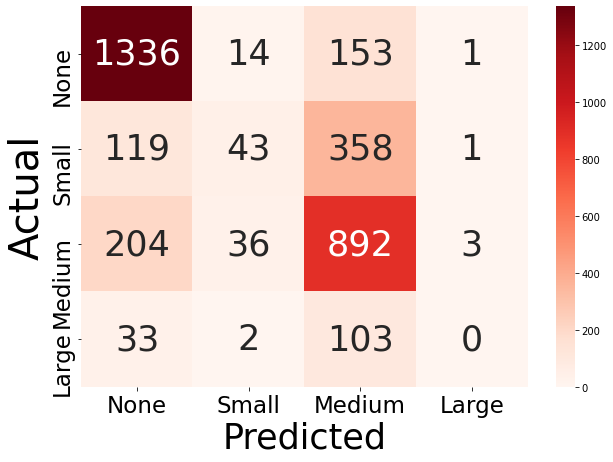

In [2]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
binary = False
if binary:
    df_cm = pd.DataFrame(array, index = [i for i in ["No", "Yes"]],
                    columns = [i for i in ["No", "Yes"]])
else:
    df_cm = pd.DataFrame(array, index = [i for i in ["None", "Small", "Medium", "Large"]],
                  columns = [i for i in ["None", "Small", "Medium", "Large"]])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size":35}, fmt='g')
ax.tick_params(axis='both', which='major', labelsize=23)
plt.xlabel('Predicted', fontsize = 35) 
# plt.title("KNN Confusion Matrix", fontsize = 50)
plt.ylabel('Actual', fontsize = 40) 
plt.savefig("SVC Multi Matrix", bbox_inches="tight")

plt.show()